In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import pickle

#### Record versions

In [2]:
!python -V

Python 3.12.3


In [3]:
!pip3 list | grep scikit

scikit-learn              1.5.0


### Downloading the data
Using January 2023 dataset for training, February 2023 dataset for validation, both for yellow cab.
Check columns in January dataset.

In [4]:
!ls ../data/

yellow_tripdata_2023-01.parquet yellow_tripdata_2023-02.parquet


In [5]:
train_dataset = '../data/yellow_tripdata_2023-01.parquet'
val_dataset = '../data/yellow_tripdata_2023-02.parquet'

In [6]:
df = pd.read_parquet(train_dataset)
len(df.columns)

19

In [7]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

### Computing duration
Standard deviation of the trips duration in January

In [8]:
df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration.std()

Timedelta('0 days 00:42:35.661074')

### Drop Outliers
What fraction of the records are left after dropping the outliers?

In [9]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    # calculate duration from data provided
    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: round((td.seconds / 60), 0))

    # drop outliers
    df = df[(df.duration >=1) & (df.duration <= 60)]

    # prep data for DictVectorizer
    categorical = ["PULocationID", "DOLocationID"]
    numeric = ["trip_distance"]
    df[categorical] = df[categorical].astype(str)
    dv_dict = df[categorical + numeric].to_dict(orient="records")
    
    return df, dv_dict
    

In [10]:
df_train, train_dict = read_dataframe(train_dataset)
df_val, val_dict = read_dataframe(val_dataset)

In [11]:
len(df_train) / len(df)

0.9837790036800982

### One-hot encoding
Check the dimensionality of the OHE matrix (number of columns)?

In [12]:
dv = DictVectorizer()

In [13]:
X_train = dv.fit_transform(train_dict)
len(dv.feature_names_)

516

### Training a model
Check RMSE on training.

In [14]:
target = 'duration'
y_train = df_train[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

In [16]:
root_mean_squared_error(y_train, y_pred)

7.723924679565361

### Evaluate the model
Check the RMSE on validation

In [17]:
X_val = dv.transform(val_dict)
y_val = df_val[target].values
y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.907238447224463

### Save the model and vector matrix

In [18]:
with open("../models/24-05-17_lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

### Visualization

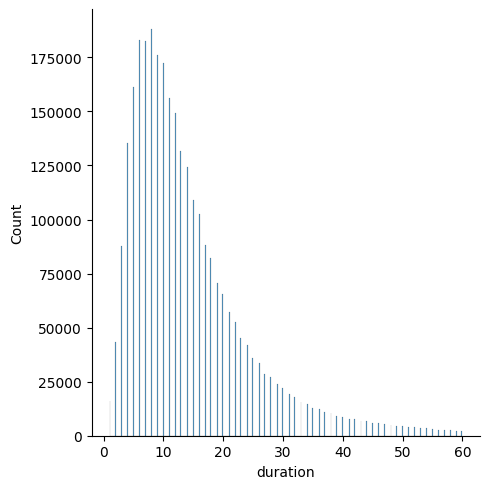

In [19]:
sns.displot(df_train.duration)

In [20]:
df_train.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    3.017020e+06
mean     1.418910e+01
std      9.985018e+00
min      1.000000e+00
50%      1.200000e+01
95%      3.500000e+01
98%      4.500000e+01
99%      5.000000e+01
max      6.000000e+01
Name: duration, dtype: float64

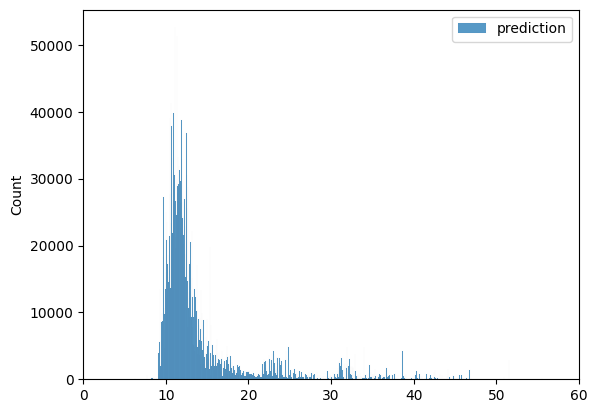

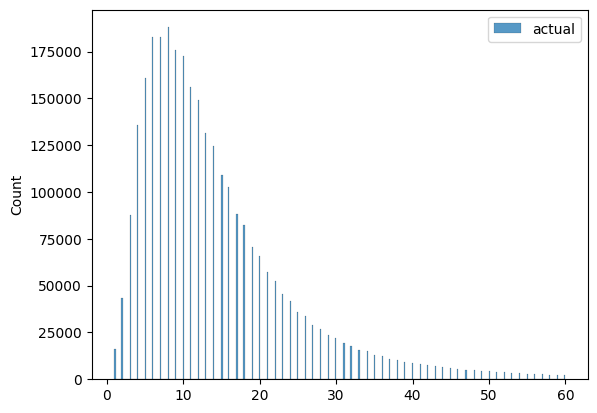

In [21]:
fig, ax = plt.subplots()
sns.histplot(y_pred, label="prediction", ax=ax)
ax.set_xlim(0,60)
plt.legend()
plt.show()

fig, ax = plt.subplots()
sns.histplot(y_train, label="actual", ax=ax)
plt.legend()
plt.show()
